In [3]:
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# file_path = 'data\\021d00N_105d81E.csv'
# df = pd.read_csv(file_path, sep=',',skiprows=9)  # Using space as separator, skipping first 2 rows
# df['Date'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MO'].astype(str).str.zfill(2) + '-' + df['DY'].astype(str).str.zfill(2))

In [2]:
dir_path ='data\data_balance'
data_frames = []
for i,file in enumerate(os.listdir(dir_path)):
    df = pd.read_csv(os.path.join(dir_path,file), sep=',',skiprows=9)  # Using space as separator, skipping first 2 rows
    df['Date'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MO'].astype(str).str.zfill(2) + '-' + df['DY'].astype(str).str.zfill(2))
    data_frames.append(df)

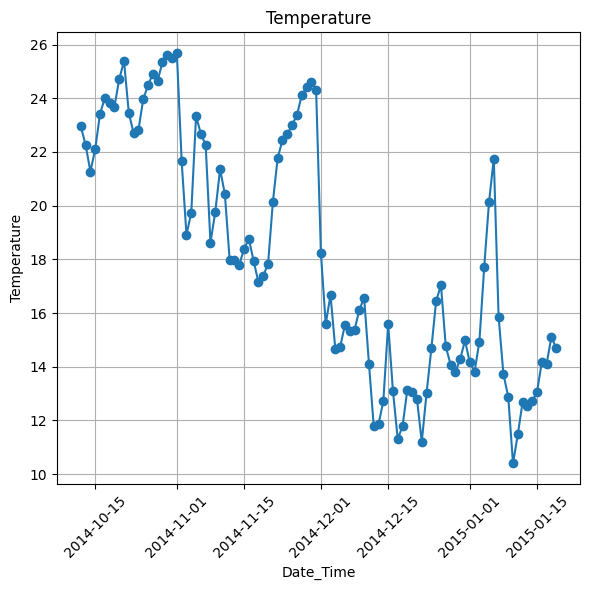

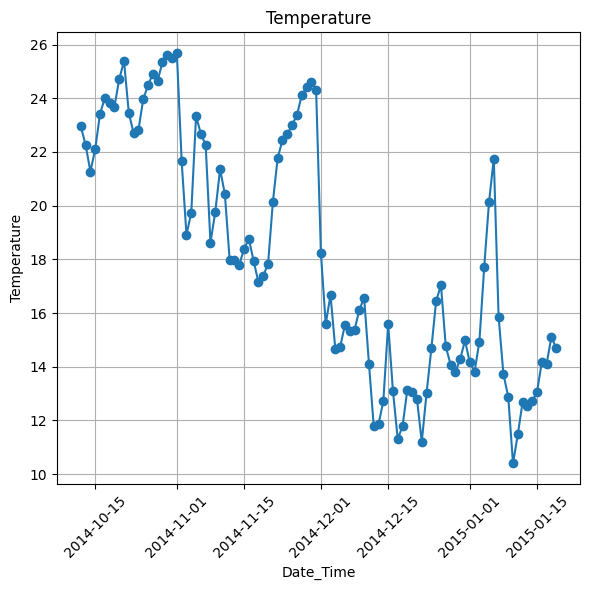

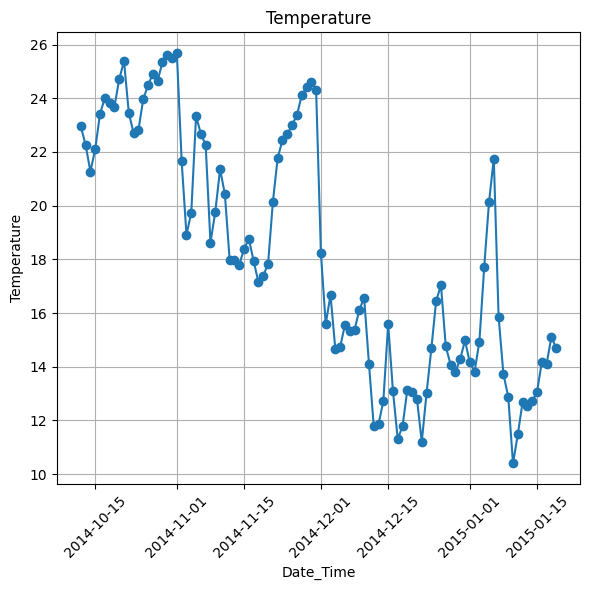

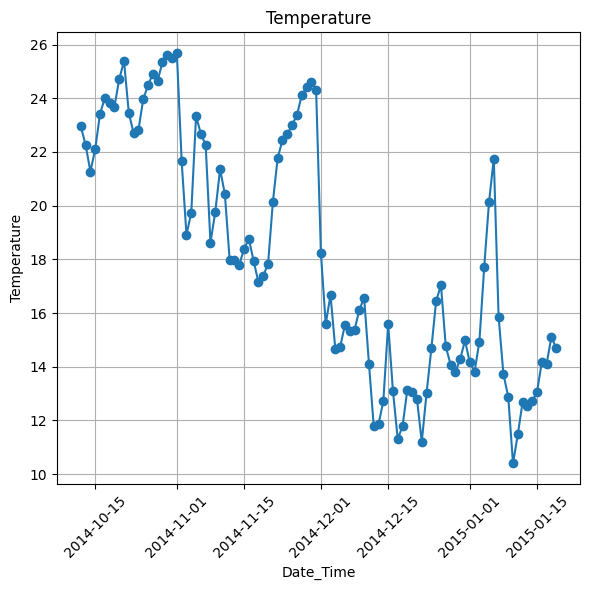

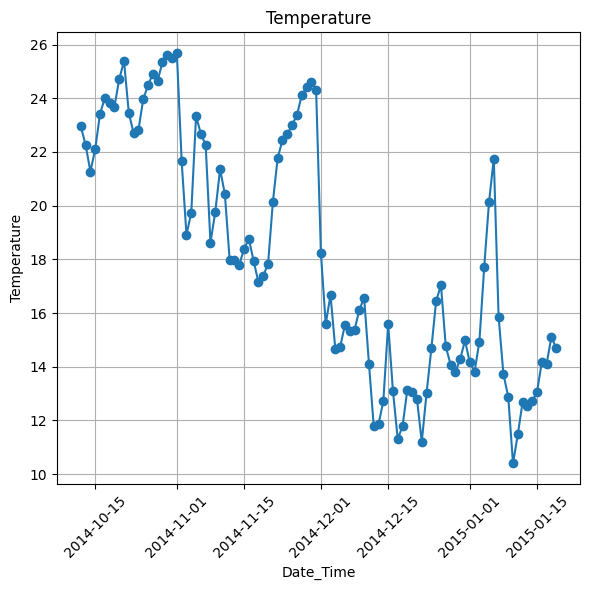

In [9]:
for i,df in enumerate(data_frames):
    data_frames_visual = df[0:100]
    plt.figure(figsize=(6, 6))
    plt.plot(data_frames_visual['Date'], data_frames_visual['T2M'], marker='o')
    plt.title(f'Temperature')
    plt.xlabel('Date_Time')
    plt.ylabel('Temperature')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid()
    # plt.ylim(-20, 50)
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()
    if i == 4:
        break

In [ ]:
# Assuming df_sorted is already defined and contains the necessary data
specific_moteid = df_sorted['Moteid'].unique # Change this to the Moteid you're interested in
specific_moteid = 1 # Change this to the Moteid you're interested in

# Filter for the specific Moteid
df_moteid_specific = df_sorted[df_sorted['Moteid'] == specific_moteid]

# Ensure 'Date_Time' is in datetime format
df_moteid_specific['Date_Time'] = pd.to_datetime(df_moteid_specific['Date'] + ' ' + df_moteid_specific['Time'])
df_moteid_specific = df_moteid_specific[(df_moteid_specific['Date'] >= '2004-03-06') & (df_moteid_specific['Date'] <= '2004-03-07')]
# df_moteid_specific = df_moteid_specific[(df_moteid_specific['Epoch'] >= 20000) & (df_moteid_specific['Epoch'] <= 25000)]

# Create a copy for fault injection
df_faulty = df_moteid_specific.copy()
df_faulty.reset_index(drop=True, inplace=True)
df_faulty_0 = df_faulty
# Add 'Fault_Label' column to mark faults (0 = normal, 1 = faulty)
df_faulty['Fault_Label'] = 0
df_faulty['Fault_type']=0

# Total number of data points to inject faults into
num_total_faults = len(df_faulty)

# Fault rates for SPF, IF, and TF
num_interval_spf = 2
fixed_fault_attemps = 2
noise_interval = 2

spf_rate = 0.05  # 5% for SPF
fixed_rate = 0.05  # 40% fixed-value faults
outlier_rate = 0.01  # 30% outlier faults
noise_rate = 0.03 # 20% high-noise faults
offset_rate = 0.01  # 10% offset faults

used_indices = set()

# Calculate the number of faults for each type
num_spf =int(spf_rate * num_total_faults)
num_fixed_faults = int(fixed_rate * num_total_faults)
num_outlier_faults = int(outlier_rate * num_total_faults)
num_noise_faults = int(noise_rate * num_total_faults)
num_offset_faults = int(offset_rate * num_total_faults)

# 1. Inject Fixed-Value Faults (0.5%)
for i in range(fixed_fault_attemps):
    fixed_value_start = np.random.choice(df_faulty.index.difference(used_indices),size=1)[0]  # Arbitrary fixed temperature value
    fixed_fault_length = np.random.randint(30,num_fixed_faults)
    fixed_value_end = fixed_value_start + fixed_fault_length
    fixed_value_end = min(fixed_value_end, df_faulty.index[-1])

    fixed_value = df_faulty_0.iloc[fixed_value_start]['Temperature']
    df_faulty.loc[fixed_value_start:fixed_value_end,'Temperature'] = fixed_value
    df_faulty.loc[fixed_value_start:fixed_value_end, 'Fault_Label'] = 1
    df_faulty.loc[fixed_value_start:fixed_value_end, 'Fault_type'] = 1

    used_indices.update(range(fixed_value_start-20, fixed_value_end + 1+20))



# 3. Inject High-Noise Faults (0.5%)
noise_fault_indices = np.random.choice(df_faulty.index, size=num_noise_faults, replace=False)
# Add random noise to the temperature (normal temperature ± 10 degrees of noise)
for i in range(noise_interval):
    gau_noise_start = np.random.choice(df_faulty.index.difference(used_indices))  # Arbitrary fixed temperature value
    gau_noise_len = np.random.randint(30,num_noise_faults+1)
    gau_noise_end = gau_noise_start + gau_noise_len
    gau_noise_end = min(gau_noise_end, df_faulty.index[-1])
    
    temperature_range = df_faulty_0.loc[gau_noise_start:gau_noise_end, 'Temperature']

    # Generate noise with a mean based on the actual values in the range and standard deviation of 1
    print(np.mean(temperature_range))
    noise = np.random.normal(np.mean(temperature_range), 1, size=len(temperature_range))

    df_faulty.loc[gau_noise_start:gau_noise_end,'Temperature'] = noise
    df_faulty.loc[gau_noise_start:gau_noise_end, 'Fault_Label'] = 1
    df_faulty.loc[gau_noise_start:gau_noise_end, 'Fault_type'] = 2

    used_indices.update(range(gau_noise_start-20, gau_noise_end + 1+20))
    



# 1. Inject Soft Permanent Fault (SPF)
# Apply a constant offset from a random starting point until the end of the data
for i in range(num_interval_spf):
    spf_start_idx = np.random.choice(df_faulty.index.difference(used_indices), size=1)[0]
    spf_end_idx = spf_start_idx + num_spf

    # Ensure the end index does not exceed the data length
    spf_end_idx = min(spf_end_idx, len(df_faulty) - 1)
    # Apply a constant offset to the temperature for the entire interval
    df_faulty.loc[spf_start_idx:spf_end_idx,'Temperature'] = df_faulty_0[spf_start_idx:spf_end_idx]['Temperature']+np.random.uniform(2.5,2,size = spf_end_idx-spf_start_idx)  # Adding a constant offset of 5 degrees
    df_faulty.loc[spf_start_idx:spf_end_idx, 'Fault_Label'] = 1
    df_faulty.loc[spf_start_idx:spf_end_idx, 'Fault_type'] = 3
    used_indices.update(range(spf_start_idx-20, spf_end_idx + 1+20))

# 2. Inject Outlier Faults (0.5%)
outlier_fault_indices = np.random.choice(df_faulty.index.difference(used_indices), size=num_outlier_faults, replace=False
) 
# Inject extreme random outliers (e.g., values between -50 and 150)
df_faulty.loc[outlier_fault_indices, 'Temperature'] = np.random.uniform(10, 35, size=num_outlier_faults)
df_faulty.loc[outlier_fault_indices, 'Fault_Label'] = 1
df_faulty.loc[outlier_fault_indices, 'Fault_type'] = 4

used_indices.update(outlier_fault_indices)

# 4. Inject Offset Faults (10%)
offset_fault_indices = np.random.choice(
    df_faulty.index.difference(used_indices),
    size=num_offset_faults, replace=False
)
# Apply a constant offset (e.g., adding 5 degrees)
df_faulty.loc[offset_fault_indices, 'Temperature'] += np.random.uniform(0,10)
df_faulty.loc[offset_fault_indices, 'Fault_Label'] = 1
df_faulty.loc[offset_fault_indices, 'Fault_type'] = 5

used_indices.update(offset_fault_indices)

# Plotting the Temperature data with faults
plt.figure(figsize=(12, 6))
plt.plot(df_faulty['Epoch'], df_faulty['Temperature'], marker='o', label='Temperature',linestyle='None')
plt.title(f'Temperature Over Time with Fault Injection (Moteid {specific_moteid})')
plt.xlabel('Epoch')
plt.ylabel('Temperature')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylim(0, 40)  # Set y-axis limits between 0 and 100
plt.grid()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.legend()
plt.show()

# Plot the normal (non-faulty) data in blue
normal_data = df_faulty[df_faulty['Fault_Label'] == 0]
plt.plot(normal_data['Epoch'], normal_data['Temperature'], marker='o', linestyle='None', color='blue', label='Normal')

# Plot fixed-value faults (type 1) in red
fixed_value_faults = df_faulty[df_faulty['Fault_type'] == 1]
plt.plot(fixed_value_faults['Epoch'], fixed_value_faults['Temperature'], marker='o', linestyle='None', color='red', label='Fixed-Value Fault')

# Plot high-noise faults (type 2) in green
high_noise_faults = df_faulty[df_faulty['Fault_type'] == 2]
plt.plot(high_noise_faults['Epoch'], high_noise_faults['Temperature'], marker='o', linestyle='None', color='green', label='High-Noise Fault')

# Plot soft permanent faults (SPF) (type 3) in orange
spf_faults = df_faulty[df_faulty['Fault_type'] == 3]
plt.plot(spf_faults['Epoch'], spf_faults['Temperature'], marker='o', linestyle='None', color='orange', label='Soft Permanent Fault')

# Plot outlier faults (type 4) in purple
outlier_faults = df_faulty[df_faulty['Fault_type'] == 4]
plt.plot(outlier_faults['Epoch'], outlier_faults['Temperature'], marker='o', linestyle='None', color='purple', label='Outlier Fault')

# Plot offset faults (type 5) in brown
offset_faults = df_faulty[df_faulty['Fault_type'] == 5]
plt.plot(offset_faults['Epoch'], offset_faults['Temperature'], marker='o', linestyle='None', color='brown', label='Offset Fault')

# Set up plot labels and title
plt.title(f'Temperature Over Time with Fault Injection (Moteid {specific_moteid})')
plt.xlabel('Epoch')
plt.ylabel('Temperature')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylim(0, 40)  # Set y-axis limits between 0 and 100
plt.grid()

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

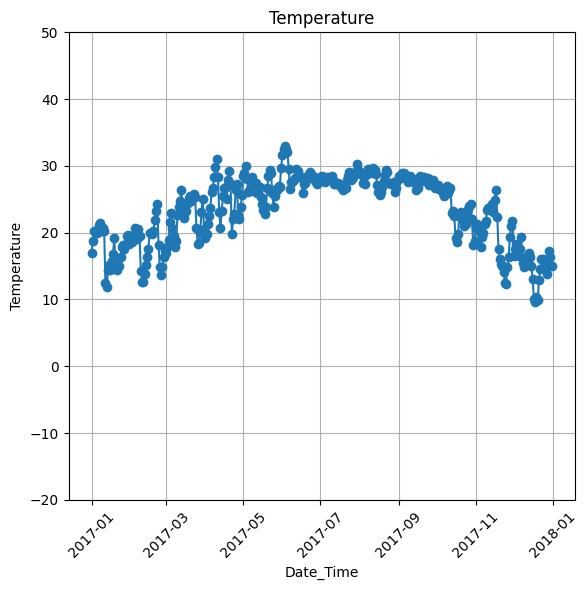

In [14]:
# Year 2019 
for df in data_frames:
    df_year = df[(df['Date'] >= '2017-01-01') & (df['Date'] <= '2017-12-31')]
    plt.figure(figsize=(6, 6))
    plt.plot(df_year['Date'], df_year['T2M'], marker='o')
    plt.title(f'Temperature')
    plt.xlabel('Date_Time')
    plt.ylabel('Temperature')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid()
    plt.ylim(-20, 50)
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()
    break